## Small simulated inputs

In [ ]:
import torch
from alphagenome_pytorch import AlphaGenome

model = AlphaGenome(num_organisms=2)
model.add_reference_heads("human")
model.add_reference_heads("mouse")


/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/torch/nn/modules/linear.py:124: UserWarning: Initializing zero-element tensors is a no-op
  init.kaiming_uniform_(self.weight, a=math.sqrt(5))


In [18]:
# Create dummy DNA input
dna = torch.randint(0, 4, (4, 8192))

# Organism that each sequence belongs to
organism_index = torch.tensor([0, 0, 1, 1])

# Define splice site positions (3 sites per sequence as example)
splice_donor_idx = torch.tensor([[10, 100, 200], [20, 150, 300], [30, 250, 350], [40, 300, 400]])
splice_acceptor_idx = torch.tensor([[15, 105, 205], [25, 155, 305], [35, 255, 355], [45, 305, 405]])

In [19]:
# Get sequence embeddings
embeds_1bp, embeds_128bp, embeds_pair = model(
    dna, 
    organism_index=organism_index,
    return_embeds=True
)

In [20]:
# Get track predictions
predictions = model(
    dna, 
    organism_index=organism_index,
    splice_donor_idx=splice_donor_idx,
    splice_acceptor_idx=splice_acceptor_idx
)

# predictions is a dict like: {'mouse': {'1bp_tracks': ..., 'splice_logits': ..., 'splice_usage': ..., 'splice_juncs': ...}}
for organism, outputs in predictions.items():
    for head_name, values in outputs.items():
        print(f"{organism} {head_name}: {values.shape}")

mouse 1bp_tracks: torch.Size([4, 8192, 1])
mouse 128bp_tracks: torch.Size([4, 64, 0])
mouse contact_head: torch.Size([4, 4, 4, 0])
mouse splice_logits: torch.Size([4, 8192, 5])
mouse splice_usage: torch.Size([4, 8192, 16])
mouse splice_juncs: torch.Size([4, 3, 3, 16])
human 1bp_tracks: torch.Size([4, 8192, 1])
human 128bp_tracks: torch.Size([4, 64, 0])
human contact_head: torch.Size([4, 4, 4, 0])
human splice_logits: torch.Size([4, 8192, 5])
human splice_usage: torch.Size([4, 8192, 14])
human splice_juncs: torch.Size([4, 3, 3, 14])


In [25]:
splice_logits = predictions['human']['splice_logits'][0:2]
splice_labels = splice_logits.argmax(dim=-1)
splice_labels

tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]])

In [36]:
splice_logits = predictions['mouse']['splice_logits'][2:]
splice_labels = splice_logits.argmax(dim=-1)
splice_labels

tensor([[1, 0, 1,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]])

## Small processed data

Load data for prediction

In [1]:
%load_ext autoreload
%autoreload 2
from alphagenome_pytorch import SpliceDataset

# Path to test data
test_data_dir = '/home/elek/sds/sd17d003/Anamaria/splicevo/data/splits_adult_10kb/mouse_human/test/'

target_length = 10240
max_donor_sites = 20
max_acceptor_sites = 20

species_mapping = {
    'human': 0,
    'mouse': 1
}

test_dataset = SpliceDataset(
    data_dir=test_data_dir,
    target_length=target_length,
    max_donor_sites=max_donor_sites,
    max_acceptor_sites=max_acceptor_sites,
    species_mapping=species_mapping
)

2026-02-09 15:15:33.601769: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-09 15:15:33.659886: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded dataset from /home/elek/sds/sd17d003/Anamaria/splicevo/data/splits_adult_10kb/mouse_human/test/


In [2]:
import pandas as pd
lbl_path = "/home/elek/sds/sd17d003/Anamaria/splicevo/data/splits_adult_10kb/mouse_human/test/labels.parquet"
labels = pd.read_parquet(lbl_path)
labels

,sample_idx,position,label
0,0,0,2
1,0,1889,1
2,0,2040,2
3,0,3938,1
4,0,4671,2
...,...,...,...
63449,9921,9078,2
63450,9921,9492,1
63451,9922,9185,1
63452,9922,9448,2


### Check that the inputs are correctly encoded

The genomic coordinates of the first sequence in the test set.

In [23]:
import os
import pandas as pd
meta_csv_fn = os.path.join(test_data_dir, "metadata.csv")
meta_csv = pd.read_csv(meta_csv_fn)

i=0
chr = str(meta_csv.loc[i, 'chromosome'])
start = int(meta_csv.loc[i, 'window_start'])
end = int(meta_csv.loc[i, 'window_end'])
strand = str(meta_csv.loc[i, 'strand'])
coord = f"{chr}:{start}-{end}"
print(coord, strand)

11:26582773-26592773 -


Extracting the corresponding fasta and gtf records for this region.

```bash
fasta_fn="/home/elek/sds/sd17d003/Anamaria/genomes/mazin/fasta/Homo_sapiens.fa.gz"
gtf_fn="/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz"
coord="11:26582773-26592773"

# Sort and index if needed
zcat /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz \
  | sort -k1,1 -k4,4n \
  | bgzip > /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.sorted.gtf.gz
tabix -p gff /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.sorted.gtf.gz
gtf_fn=/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.sorted.gtf.gz

# Extract fasta sequence
samtools faidx $fasta_fn $coord > region.fa

# Extract gtf records
tabix $gtf_fn $coord > region.gtf
```

Check that the extracted fasta region corresponds correctly to the ohe DNA in the dataset.  
Compare to:
```bash
head region.fa -n 2
```

In [66]:
dna_window = test_dataset[i]['dna']
print(dna_window[0:60])

def ohe(dna_ohe):
    """[0, 1, 2, 3] -> [A, C, G, T]"""
    return ''.join(['ACGT'[i] for i in dna_ohe])
def rev(dna_seq):
    """Reverse complement a DNA sequence"""
    complement = str.maketrans('ACGT', 'TGCA')
    return dna_seq.translate(complement)

dna_seq = ohe(dna_window)
if strand == '+':
    print(dna_seq[0:60])
if strand == '-':
    print(rev(dna_seq[0:60]))

tensor([0, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 2, 3, 3, 3, 3, 0, 3, 3, 0, 3, 2, 0, 1,
        0, 0, 0, 2, 3, 2, 3, 1, 0, 1, 3, 0, 3, 2, 0, 2, 0, 1, 3, 3, 3, 1, 3, 0,
        0, 2, 3, 0, 1, 0, 0, 2, 3, 1, 1, 2])
TAAAAAAGTAACAAAATAATACTGTTTCACAGTGATACTCTGAAAGATTCATGTTCAGGC


Check that splice site coordinates are correct.  
Compare to:
```bash
head region.gtf
```

In [115]:
splice_sites = test_dataset[i]['splice_labels']

splice_donor_idx = test_dataset[i]['splice_donor_idx'].unique().numpy()
splice_acceptor_idx = test_dataset[i]['splice_acceptor_idx'].unique().numpy()

splice_donor_encode = splice_sites[splice_donor_idx].numpy()
splice_acceptor_encode = splice_sites[splice_acceptor_idx].numpy()

splice_donor_count = len(splice_sites[splice_sites == splice_donor_encode[0]])
splice_acceptor_count = len(splice_sites[splice_sites == splice_acceptor_encode[0]])

# Check that encoding at splice sites corresponds to idx 
print(f"\nDonors: {splice_donor_idx}")
print(f"Genomic coordinates: {[int(start + idx) for idx in splice_donor_idx]}")
print(f"Donors on {strand} strand encoded as: {splice_donor_encode}")
print(f"There are {splice_donor_count} donor sites in this sequence.")

print(f"\nAcceptors: {splice_acceptor_idx}")
print(f"Genomic coordinates: {[int(start + idx) for idx in splice_acceptor_idx]}")
print(f"Acceptors on {strand} strand encoded as: {splice_acceptor_encode}")
print(f"There are {splice_acceptor_count} acceptor sites in this sequence.")


Donors: [1889 3938 5825]
Genomic coordinates: [26584662, 26586711, 26588598]
Donors on - strand encoded as: [2 2 2]
There are 3 donor sites in this sequence.

Acceptors: [   0 2040 4671 5914]
Genomic coordinates: [26582773, 26584813, 26587444, 26588687]
Acceptors on - strand encoded as: [3 3 3 3]
There are 4 acceptor sites in this sequence.


***

### Subset _n_ sequences for prediction

First _n_ sequences from the test set.

In [7]:
import torch
import numpy as np

n = 60

dna = []
for i in range(n):
# sample random n indices from the test dataset
#for i in np.random.choice(len(test_dataset), n, replace=False):
    dna.append(test_dataset[i]['dna'])
dna = torch.stack(dna)
print(dna.shape)
dna

torch.Size([60, 10240])


tensor([[ 3,  0,  0,  ..., -1, -1, -1],
        [ 3,  1,  0,  ..., -1, -1, -1],
        [ 2,  3,  0,  ..., -1, -1, -1],
        ...,
        [ 0,  1,  0,  ..., -1, -1, -1],
        [ 1,  1,  3,  ..., -1, -1, -1],
        [ 3,  0,  0,  ..., -1, -1, -1]])

Organism that the first _n_ sequences belong to.

In [8]:
organism_index = []
for i in range(n):
    organism_index.append(test_dataset[i]['organism_index'])

organism_index = torch.tensor(organism_index)
print(organism_index.shape)
organism_index

torch.Size([60])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Splice labels

In [9]:
splice_labels = []
for i in range(n):
    splice_labels.append(test_dataset[i]['splice_labels'])
splice_labels = torch.stack(splice_labels)
print(splice_labels.shape)
splice_labels

torch.Size([60, 10240])


tensor([[4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        ...,
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4]])

Splice usage

In [10]:
splice_usage = []
for i in range(n):
    conds = test_dataset[i]['conditions_mask']
    splice_usage.append(test_dataset[i]['splice_usage_target'][:, conds])
splice_usage = torch.stack(splice_usage)
print(splice_usage.shape)
splice_usage

torch.Size([60, 10240, 16])


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 1.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

### Load pretrained model

Model architecture

In [11]:
import torch
from alphagenome_pytorch import AlphaGenome

model = AlphaGenome(num_organisms=2)
model.add_reference_heads("human")
#model.add_reference_heads('mouse')
model.load_from_official_jax_model("all_folds")

/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No GPU available, using CPU device: TFRT_CPU_0
Loading checkpoint (model_version=all_folds)...


Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 152983.73it/s]
/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/pyfaidx/__init__.py:589: UserWarning: for fsspec: HTTPFileSystem assuming index is current
  warnings.warn("for fsspec: %s assuming index is current" % type(self._fs).__name__)
/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/pyfaidx/__init__.py:589: UserWarning: for fsspec: HTTPFileSystem assuming index is current
  warnings.warn("for fsspec: %s assuming index is current" % type(self._fs).__name__)


  Loaded 589 parameter arrays
  Loaded 81 state arrays

Converting 545 parameter mappings...
Converting 81 state mappings...

Converted 653 tensors to PyTorch state_dict


AlphaGenome(
  (transformer_unet): TransformerUnet(
    (dna_embed): DNAEmbed(
      (conv): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=(7,))
      (pointwise): ConvBlock(
        (net): Sequential(
          (0): BatchRMSNorm()
          (1): GELU1702()
          (2): WeightStandardConv(768, 768, kernel_size=(5,), stride=(1,), padding=(2,))
        )
      )
      (pool): Reduce('b d (n pool) -> b d n', 'max', pool=2)
    )
    (downs): ModuleList(
      (0): DownresBlock(
        (conv): ConvBlock(
          (net): Sequential(
            (0): BatchRMSNorm()
            (1): GELU1702()
            (2): WeightStandardConv(768, 896, kernel_size=(5,), stride=(1,), padding=(2,))
          )
        )
        (conv_out): ConvBlock(
          (net): Sequential(
            (0): BatchRMSNorm()
            (1): GELU1702()
            (2): WeightStandardConv(896, 896, kernel_size=(5,), stride=(1,), padding=(2,))
          )
        )
        (max_pool): Reduce('b d (n pool) -> b d

Get track predictions.

Model is supposed to get splice logits right since these are the same predictions as the model was trained on. Splice usage is not expected to be accurate since model was not trained on and doesn't predict these samples.

In [12]:
predictions = model.inference(
    dna, 
    organism_index=organism_index,
    requested_heads=['splice_sites_classification', 'splice_sites_usage']
)

### Predictions

In [13]:
predictions['human'].keys()

dict_keys(['splice_sites_classification', 'splice_sites_usage'])

In [ ]:
splice_logits = predictions['human']['splice_sites_classification']
print(splice_logits.shape)

torch.Size([60, 10240, 5])


In [15]:
splice_labels_pred = splice_logits.argmax(dim=-1)
print(splice_labels_pred.shape)
splice_labels_pred

torch.Size([60, 10240])


tensor([[4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        ...,
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4]])

In [16]:
# Get count of true classes
print("\nTrue labels distribution:")
splice_label_flat = splice_labels.flatten().numpy()
for i in range(5):
    count = np.sum(splice_label_flat == i)
    print(f"Class {i}: {count} predictions")

# Get count of predicted classes
print("Predicted labels distribution:")
splice_label_pred_flat = splice_labels_pred.flatten().numpy()
for i in range(5):
    count = np.sum(splice_label_pred_flat == i)
    print(f"Class {i}: {count} predictions")



True labels distribution:
Class 0: 91 predictions
Class 1: 83 predictions
Class 2: 38 predictions
Class 3: 42 predictions
Class 4: 614146 predictions
Predicted labels distribution:
Class 0: 80 predictions
Class 1: 80 predictions
Class 2: 34 predictions
Class 3: 34 predictions
Class 4: 614172 predictions


In [17]:
import numpy as np

splice_logits = predictions['human']['splice_sites_classification']
splice_logits_flat = splice_logits.reshape(-1, splice_logits.shape[-1])
splice_labels_flat = splice_labels.reshape(-1)

splice_results = {}
splice_sites_ = np.where(splice_labels != 4) # Not not-a-splice-site
for i in range(len(splice_sites_[0])):
    sample_idx = splice_sites_[0][i]
    position = splice_sites_[1][i]
    splice_labels_ = splice_labels[sample_idx, position].to('cpu').numpy()
    splice_logits_ = splice_logits[sample_idx, position, :]
    splice_preds_ = splice_logits_.softmax(dim=-1).to('cpu').detach().numpy()
    splice_results[i] = {
        'sample_idx': sample_idx,
        'position': position,
        'label': splice_labels_,
        'pred_0': splice_preds_[0],
        'pred_1': splice_preds_[1],
        'pred_2': splice_preds_[2],
        'pred_3': splice_preds_[3],
        'pred_4': splice_preds_[4]
    }

import pandas as pd
splice_df = pd.DataFrame.from_dict(splice_results, orient='index')
splice_df

,sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4
0,0,1889,2,0.000194,0.000363,0.673784,0.000162,0.325497
1,0,2038,3,0.000214,0.000052,0.000138,0.743558,0.256038
2,0,3938,2,0.000293,0.000399,0.765660,0.000313,0.233335
3,0,4669,3,0.000306,0.000155,0.000253,0.561384,0.437902
4,0,5825,2,0.000184,0.000214,0.552572,0.000180,0.446850
...,...,...,...,...,...,...,...,...
249,58,1987,1,0.000123,0.927066,0.000112,0.000027,0.072672
250,58,2174,0,0.943161,0.000332,0.000059,0.000147,0.056302
251,58,6634,1,0.000205,0.971987,0.000108,0.000059,0.027641
252,58,7260,0,0.925486,0.000286,0.000046,0.000159,0.074022


Splice logits and true labels

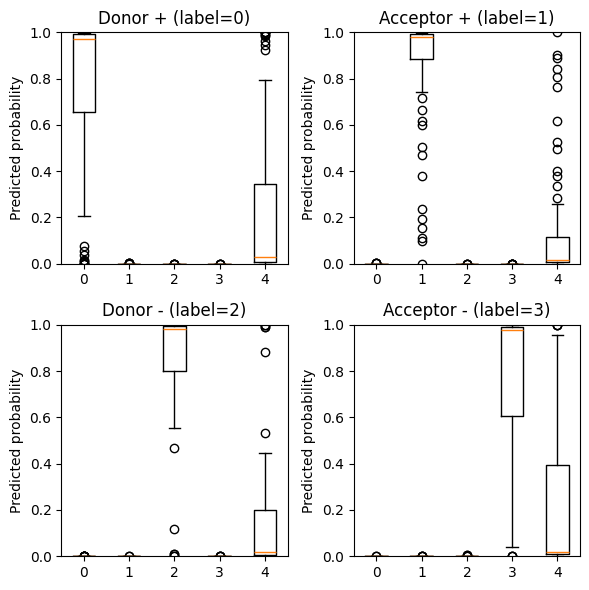

In [18]:
import matplotlib.pyplot as plt

# Plot boxplot of predicted probabilities for each class at true classes
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.title("Donor + (label=0)")
plt.boxplot([splice_df[splice_df['label'] == 0][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.ylim(0, 1)
plt.subplot(2, 2, 2)
plt.title("Acceptor + (label=1)")
plt.boxplot([splice_df[splice_df['label'] == 1][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.ylim(0, 1)
plt.subplot(2, 2, 3)
plt.title("Donor - (label=2)")
plt.boxplot([splice_df[splice_df['label'] == 2][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.ylim(0, 1)
plt.subplot(2, 2, 4)
plt.title("Acceptor - (label=3)")
plt.boxplot([splice_df[splice_df['label'] == 3][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
pr_auc_scores = {}
class_labels = {0: 'no splice site', 1: 'donor +', 2: 'acceptor +', 3: 'donor -', 4: 'acceptor -'}
class_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green', 3: 'tab:lightorange', 4: 'tab:lightgreen'}

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

plt.figure(figsize=(5, 4))
for i in range(5):
    color = class_colors[i]
    label = class_labels[i]
    
    class_idx = splice_labels_flat == i
    y_true = splice_labels_flat[class_idx]
    y_scores = splice_logits_flat[class_idx]
    
    if len(y_true) > 0 and np.sum(y_true) > 0:
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall, precision)
        pr_auc_scores[class_idx] = pr_auc
        
        plt.plot(
            recall, precision,
            label=f"{label} (AUC = {pr_auc:.3f})",
            linewidth=2,
            color=color
        )
    else:
        pr_auc_scores[class_idx] = 0.0
        print(f"  Warning: No positive samples for {label}")

Splice site usage

In [19]:
# Predicted and true splice usage
org_sse_pred = predictions['human']['splice_sites_usage']
org_sse_true = splice_usage

# Only compute loss at splice site positions (labels != 0)
splice_site_mask = splice_labels != 0  # (batch, seq_len)
donor_plus_mask = splice_labels == 1
acceptor_plus_mask = splice_labels == 2
donor_minus_mask = splice_labels == 3
acceptor_minus_mask = splice_labels == 4

if splice_site_mask.any():
    # Select only splice site positions
    usage_true_at_sites = org_sse_true[splice_site_mask] 
    usage_pred_at_sites = org_sse_pred[splice_site_mask]
    
    usage_true_at_donor_plus = org_sse_true[donor_plus_mask]
    usage_true_at_acceptor_plus = org_sse_true[acceptor_plus_mask]
    usage_true_at_donor_minus = org_sse_true[donor_minus_mask]
    usage_true_at_acceptor_minus = org_sse_true[acceptor_minus_mask]
    usage_pred_at_donor_plus = org_sse_pred[donor_plus_mask]
    usage_pred_at_acceptor_plus = org_sse_pred[acceptor_plus_mask]
    usage_pred_at_donor_minus = org_sse_pred[donor_minus_mask]
    usage_pred_at_acceptor_minus = org_sse_pred[acceptor_minus_mask]

In [47]:
usage_true_ = usage_true_at_sites.detach().cpu().numpy()
usage_pred_ = usage_pred_at_sites.detach().cpu().numpy()

In [48]:
# Flatten for plotting
ncols = usage_true_.shape[-1]
usage_true_ = usage_true_.flatten()
usage_pred_ = usage_pred_[:, 0:ncols].flatten()

In [49]:
# Group true usage in bins: 0 - 0.2 - 0.5 - 0.8 - 1.0
usage_true_bins = np.zeros_like(usage_true_, dtype=int)
usage_true_bins[usage_true_ < 0.2] = 0
usage_true_bins[(usage_true_ >= 0.2) & (usage_true_ < 0.5)] = 1
usage_true_bins[(usage_true_ >= 0.5) & (usage_true_ < 0.8)] = 2
usage_true_bins[usage_true_ >= 0.8] = 3

# Count number of values in each bin
for i in range(4):
    count = np.sum(usage_true_bins == i)
    print(f"True usage bin {i}: {count} values")

True usage bin 0: 9826399 values
True usage bin 1: 59 values
True usage bin 2: 211 values
True usage bin 3: 2275 values


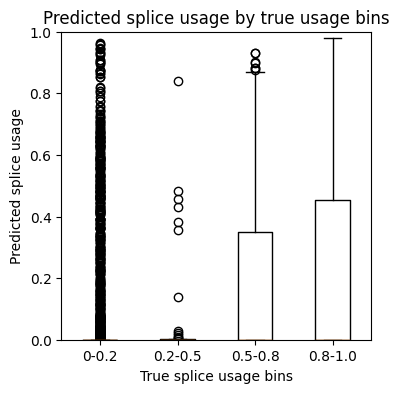

In [54]:
# Plot boxplot of predicted usage for each true usage bin
plt.figure(figsize=(4, 4))
plt.title("Predicted splice usage by true usage bins")
plt.boxplot([usage_pred_[usage_true_bins == i] for i in range(4)], tick_labels=['0-0.2', '0.2-0.5', '0.5-0.8', '0.8-1.0'])
plt.ylabel("Predicted splice usage")
plt.xlabel("True splice usage bins")
plt.ylim(0, 1)
plt.show()

Correlation between true and predicted splice usage: 0.482


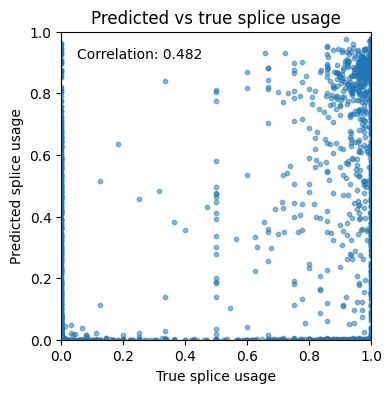

In [53]:
# calculate correlation between true and predicted usage at splice sites
correlation = np.corrcoef(usage_true_, usage_pred_)[0, 1]
print(f"Correlation between true and predicted splice usage: {correlation:.3f}")

# Plot scatter plot of predicted usage vs true usage
plt.figure(figsize=(4, 4))
plt.title("Predicted vs true splice usage")
plt.scatter(usage_true_, usage_pred_, alpha=0.5, s=10)
plt.xlabel("True splice usage")
plt.ylabel("Predicted splice usage")
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add correlation text
plt.text(0.05, 0.95, f"Correlation: {correlation:.3f}", transform=plt.gca().transAxes, verticalalignment='top')

plt.show()

## Fine-tuning on the small processed data

Modify the model to start from pretrained model and continue training on my preprocessed data.

In [5]:
import yaml
from alphagenome_pytorch.config import AlphaGenomeConfig

# Config file
config_file = '../configs/splice_finetuning.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)

# Path to training data
# data_dir = config.get('data_dir', '/home/elek/sds/sd17d003/Anamaria/splicevo/data/splits_adult_5kb/mouse_human/train/')
data_dir = '/home/elek/sds/sd17d003/Anamaria/splicevo/data/splits_small_5kb/mouse_human/train/'

# Config params
seed = config.get('seed', 1950)
seq_len = config.get('seq_len', 4096)  # Must be power of 2
batch_size = config.get('batch_size', 4)
num_workers = config.get('num_workers', 4)
epochs = config.get('epochs', 3)
lr = config.get('lr', 1e-4)
validation_fraction = config.get('validation_fraction', 0.1)
max_donor_sites = config.get('max_donor_sites', 20)
max_acceptor_sites = config.get('max_acceptor_sites', 20)

# Load pretrained weights
load_pretrained = config.get('load_pretrained', False)
pretrained_model_version = config.get('pretrained_model_version', 'all_folds')
freeze_backbone = config.get('freeze_backbone', False)

# Load pretrained model configuration
default_cfg = AlphaGenomeConfig()
model_cfg = config.get('model', {})
dims = tuple(model_cfg.get('dims', default_cfg.dims))
basepairs = model_cfg.get('basepairs', default_cfg.basepairs)
dna_embed_width = model_cfg.get('dna_embed_width', default_cfg.dna_embed_width)
num_organisms = model_cfg.get('num_organisms', default_cfg.num_organisms)
transformer_kwargs = model_cfg.get('transformer_kwargs', default_cfg.transformer_kwargs)

# Hardcoded heads configuration for splicing-only tasks
heads_cfg = {
    'human': {
        'num_tracks_1bp': 0,
        'num_tracks_128bp': 0,
        'num_tracks_contacts': 0,
        'num_splicing_contexts': 7 # adult: 16
    },
    'mouse': {
        'num_tracks_1bp': 0,
        'num_tracks_128bp': 0,
        'num_tracks_contacts': 0,
        'num_splicing_contexts': 8 # adult: 34
    }
}

Dataset

In [6]:
%load_ext autoreload
%autoreload 2
import os
import json
from alphagenome_pytorch import SpliceDataset

# Load species mapping from metadata.json
metadata_path = os.path.join(data_dir, 'metadata.json')
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

species_mapping = metadata.get('species_mapping', {
    'human': 0,
    'mouse': 1,
    'rat': 2
})

print(f"Species mapping: {species_mapping}")

target_length = 4096
max_donor_sites = 20
max_acceptor_sites = 20
num_organisms = len(species_mapping)

train_dataset = SpliceDataset(
    data_dir=data_dir,
    target_length=target_length,
    max_donor_sites=max_donor_sites,
    max_acceptor_sites=max_acceptor_sites,
    species_mapping=species_mapping
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Species mapping: {'human': 0, 'mouse': 1}
Loaded dataset from /home/elek/sds/sd17d003/Anamaria/splicevo/data/splits_small_5kb/mouse_human/train/


In [7]:
next(iter(train_dataset))

{'dna': tensor([1, 3, 2,  ..., 1, 3, 1]),
 'organism_index': tensor(0),
 'splice_donor_idx': tensor([2439, 2439, 2439, 2439, 2439, 2439, 2439, 2439, 2439, 2439, 2439, 2439,
         2439, 2439, 2439, 2439, 2439, 2439, 2439, 2439]),
 'splice_acceptor_idx': tensor([2322, 2322, 2322, 2322, 2322, 2322, 2322, 2322, 2322, 2322, 2322, 2322,
         2322, 2322, 2322, 2322, 2322, 2322, 2322, 2322]),
 'num_donors': tensor(1),
 'num_acceptors': tensor(1),
 'splice_labels': tensor([4, 4, 4,  ..., 4, 4, 4]),
 'splice_usage_target': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'conditions_mask': tensor([0, 1, 2, 3, 5, 6, 7])}

Architecture

In [8]:
from alphagenome_pytorch import AlphaGenome

model = AlphaGenome(dims, basepairs, dna_embed_width, num_organisms, transformer_kwargs)

# Add splicing heads only (no tracks or contact maps)
for organism, head_cfg in heads_cfg.items():
    model.add_heads(organism=organism, **head_cfg)

print("Total model parameters:", model.total_parameters)

Total model parameters: 405516192


/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/torch/nn/modules/linear.py:124: UserWarning: Initializing zero-element tensors is a no-op
  init.kaiming_uniform_(self.weight, a=math.sqrt(5))


In [9]:
# Load pretrained weights if specified
if load_pretrained:
    print(f"Loading pretrained weights from {pretrained_model_version}...")
    model.load_from_official_jax_model(pretrained_model_version, strict=False)
    print("Pretrained weights loaded successfully")
    
    # Optionally freeze backbone
    if freeze_backbone:
        print("Freezing transformer backbone...")
        for param in model.transformer_unet.parameters():
            param.requires_grad = False
        
        # Keep heads trainable
        for organism, heads in model.heads.items():
            for head in heads.values():
                for param in head.parameters():
                    param.requires_grad = True
        
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Trainable parameters (heads only): {trainable_params:,}")

Loading pretrained weights from all_folds...


/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No GPU available, using CPU device: TFRT_CPU_0
Loading checkpoint (model_version=all_folds)...


Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 155825.54it/s]
/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/pyfaidx/__init__.py:589: UserWarning: for fsspec: HTTPFileSystem assuming index is current
  warnings.warn("for fsspec: %s assuming index is current" % type(self._fs).__name__)
/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/pyfaidx/__init__.py:589: UserWarning: for fsspec: HTTPFileSystem assuming index is current
  warnings.warn("for fsspec: %s assuming index is current" % type(self._fs).__name__)


  Loaded 589 parameter arrays
  Loaded 81 state arrays

Converting 545 parameter mappings...
Converting 81 state mappings...

Converted 653 tensors to PyTorch state_dict
Pretrained weights loaded successfully
Freezing transformer backbone...
Trainable parameters (heads only): 12,272,153


Split into train and validation (stratified by species)

In [10]:
import numpy as np

dataset_size = len(train_dataset)
val_size = int(dataset_size * validation_fraction)
train_size = dataset_size - val_size

# Get species labels for stratified split
species_labels = []
for idx in range(dataset_size):
    species_id = train_dataset.species.iloc[idx]
    # If it is integer, use directly, otherwise if string (species name), map to index
    if isinstance(species_id, (int, np.integer)):
        organism_idx = int(species_id)
    else:
        organism_idx = train_dataset.species_mapping.get(species_id, 0)
    species_labels.append(organism_idx)
species_labels = np.array(species_labels)

In [11]:
from torch.utils.data import Subset

# Stratified split - ensure each species is represented proportionally
train_indices = []
val_indices = []

for organism_idx in np.unique(species_labels):
    # Get all indices for this organism
    org_indices = np.where(species_labels == organism_idx)[0]
    n_org = len(org_indices)
    n_val_org = int(n_org * validation_fraction)
    
    # Shuffle within organism
    np.random.shuffle(org_indices)
    
    # Split
    val_indices.extend(org_indices[:n_val_org])
    train_indices.extend(org_indices[n_val_org:])


# Shuffle the combined indices
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)

# Create subset datasets
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

In [12]:
# Print species distribution
train_species = species_labels[train_indices]
val_species = species_labels[val_indices]
print(f"Dataset split: {len(train_indices)} train, {len(val_indices)} validation")
for organism_idx in np.unique(species_labels):
    organism_name = [k for k, v in species_mapping.items() if v == organism_idx]
    organism_name = organism_name[0] if organism_name else f"organism_{organism_idx}"
    train_count = np.sum(train_species == organism_idx)
    val_count = np.sum(val_species == organism_idx)
    print(f"  {organism_name}: {train_count} train, {val_count} val")

Dataset split: 24947 train, 2771 validation
  human: 14101 train, 1566 val
  mouse: 10846 train, 1205 val


In [13]:
from torch.utils.data import DataLoader
from alphagenome_pytorch.samplers import SpeciesGroupedSampler

train_sampler = SpeciesGroupedSampler(train_subset, batch_size=batch_size, shuffle=True)
val_sampler = SpeciesGroupedSampler(val_subset, batch_size=batch_size, shuffle=False)

train_loader = DataLoader(
    train_subset,
    batch_sampler=train_sampler,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_sampler=val_sampler,
    num_workers=num_workers,
    pin_memory=True
)

Optimizer

In [14]:
import torch

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=lr,
    weight_decay=0.01
)

In [15]:
from accelerate import Accelerator

# prepare accelerator for distributed
accelerate_kwargs = {}
accelerator = Accelerator(**accelerate_kwargs)
model, train_loader, val_loader, optimizer = accelerator.prepare(model, train_loader, val_loader, optimizer)
device = accelerator.device

Loss functions

In [16]:
import torch.nn as nn
from alphagenome_pytorch import JunctionsLoss

# losses for splicing tasks only
loss_fns = {
    'splice_logits': nn.CrossEntropyLoss(),
    'splice_usage': nn.BCELoss(),
    'splice_juncs': JunctionsLoss()
}

A function to train one epoch

In [17]:
def get_organism_name(organism_idx, species_mapping):
    """Map organism index to organism name used in model heads"""
    # Invert species_mapping to go from index to name
    for name, idx in species_mapping.items():
        if idx == organism_idx:
            return name
    return f'organism_{organism_idx}'

def exists(v):
    return v is not None


In [18]:
def train_one_epoch(model, dataloader, optimizer, loss_fns, device, species_mapping, accelerator: Accelerator | None = None):
    model.train()
    total_loss = 0.0
    total_splice_logits_loss = 0.0
    total_splice_usage_loss = 0.0
    total_splice_juncs_loss = 0.0
    num_batches = 0

    for batch in dataloader:
        # Move inputs to device
        dna = batch['dna'].to(device)
        organism_index = batch['organism_index'].to(device)
        splice_donor_idx = batch['splice_donor_idx'].to(device)
        splice_acceptor_idx = batch['splice_acceptor_idx'].to(device)
        context_indices_map = batch['conditions_mask'].to(device)
        
        # Targets
        splice_labels = batch['splice_labels'].to(device)  # (batch, seq_len)
        splice_usage_target = batch['splice_usage_target'].to(device)  # (batch, seq_len, num_contexts)

        # Forward pass
        preds = model(
            dna,
            organism_index,
            splice_donor_idx=splice_donor_idx,
            splice_acceptor_idx=splice_acceptor_idx
        )
        
        # Since batches are species-specific, preds should only contain one organism
        # assert len(preds) == 1, f"Expected 1 organism in batch, got {len(preds)}"
        # But the model actually calculates predictions for both species
        # so I will only use predictions for batch species for loss calculation

        # Compute losses for batch organism
        losses = []
        batch_organism = organism_index.unique().tolist()
        for org_name, org_preds in preds.items():
            # Skip organisms not in this batch
            if org_name not in [get_organism_name(org_idx, species_mapping) for org_idx in batch_organism]:
                continue
            # Splice logits loss (5-class classification: none, donor, acceptor, etc.)
            if 'splice_logits' in org_preds:
                splice_logits = org_preds['splice_logits']  # (batch, seq_len, 5)
                # Reshape for cross entropy
                splice_logits_flat = splice_logits.reshape(-1, splice_logits.shape[-1])
                splice_labels_flat = splice_labels.reshape(-1)
                splice_logits_loss = loss_fns['splice_logits'](splice_logits_flat, splice_labels_flat)
                losses.append(splice_logits_loss)
                total_splice_logits_loss += splice_logits_loss.item()
            
            # Splice usage loss (per-context usage prediction)
            if 'splice_usage' in org_preds:
                splice_usage = org_preds['splice_usage']  # (batch, seq_len, num_contexts_for_organism)
            
                # Get which SSE columns this organism uses
                sse_columns = context_indices_map[0]  # Get first element since all in batch are same organism
                
                # Since batches are species-specific, all sequences are from this organism
                # Select only the relevant SSE columns for this organism
                org_sse_target = splice_usage_target[:, :, sse_columns]  # (batch, seq_len, num_contexts_for_organism)
                
                # Only compute loss at splice site positions (labels != 0)
                splice_site_mask = splice_labels != 0  # (batch, seq_len)
                
                if splice_site_mask.any():
                    # Select only splice site positions
                    splice_usage_at_sites = splice_usage[splice_site_mask]  # (num_sites, num_contexts)
                    org_sse_target_at_sites = org_sse_target[splice_site_mask]  # (num_sites, num_contexts)
                    
                    # Check for NaN/Inf in targets and replace with zeros
                    if torch.isnan(org_sse_target_at_sites).any() or torch.isinf(org_sse_target_at_sites).any():
                        org_sse_target_at_sites = torch.nan_to_num(org_sse_target_at_sites, nan=0.0, posinf=1.0, neginf=0.0)
                    
                    # Skip if predictions contain NaN
                    if not (torch.isnan(splice_usage_at_sites).any() or torch.isinf(splice_usage_at_sites).any()):
                        # Compute MSE loss
                        splice_usage_loss = loss_fns['splice_usage'](splice_usage_at_sites, org_sse_target_at_sites)
                        
                        if not torch.isnan(splice_usage_loss):
                            losses.append(splice_usage_loss)
                            total_splice_usage_loss += splice_usage_loss.item()

            
            # Splice junction loss (donor-acceptor pairings)
            if 'splice_juncs' in org_preds:
                splice_juncs = org_preds['splice_juncs']  # (batch, num_donors, num_acceptors, num_contexts)
                # Create target junction matrix (placeholder - adjust based on your data)
                # For now, use a simple loss
                splice_juncs_loss = loss_fns['splice_juncs'](splice_juncs, splice_juncs)  # Placeholder
                losses.append(splice_juncs_loss * 0)  # Weight down for now
                total_splice_juncs_loss += splice_juncs_loss.item()

        if len(losses) == 0:
            continue
            
        loss = torch.stack(losses).sum()

        # Backpropagation
        if exists(accelerator):
            accelerator.backward(loss)
        else:
            loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        num_batches += 1    

    avg_loss = total_loss / max(num_batches, 1)    
    avg_splice_juncs_loss = total_splice_juncs_loss / max(num_batches, 1)
    avg_splice_logits_loss = total_splice_logits_loss / max(num_batches, 1)    
    avg_splice_usage_loss = total_splice_usage_loss / max(num_batches, 1)
    
    return avg_loss, avg_splice_logits_loss, avg_splice_usage_loss, avg_splice_juncs_loss

A function to run validation epoch

In [19]:
@torch.no_grad()
def validate_one_epoch(model, val_loader, loss_fns, species_mapping, accelerator=None, device='cuda'):
    """Run validation and return average loss."""
    model.eval()
    
    total_loss = 0.0
    total_splice_logits_loss = 0.0
    total_splice_usage_loss = 0.0
    total_splice_juncs_loss = 0.0
    num_batches = 0

    for batch in val_loader:
        dna = batch['dna'].to(device)
        organism_index = batch['organism_index'].to(device)
        splice_donor_idx = batch['splice_donor_idx'].to(device)
        splice_acceptor_idx = batch['splice_acceptor_idx'].to(device)
        splice_labels = batch['splice_labels'].to(device)
        splice_usage_target = batch['splice_usage_target'].to(device)
        context_indices_map = batch['conditions_mask'].to(device)

        # Forward pass
        preds = model(
            dna,
            organism_index=organism_index,
            splice_donor_idx=splice_donor_idx,
            splice_acceptor_idx=splice_acceptor_idx
        )

        # Compute losses for batch organisms only
        losses = []
        batch_organism = organism_index.unique().tolist()
        
        for org_name, org_preds in preds.items():
            # Skip organisms not in this batch
            if org_name not in [get_organism_name(org_idx, species_mapping) for org_idx in batch_organism]:
                continue
            # Splice logits loss
            if 'splice_logits' in org_preds:
                splice_logits = org_preds['splice_logits']
                splice_logits_flat = splice_logits.reshape(-1, splice_logits.shape[-1])
                splice_labels_flat = splice_labels.reshape(-1)
                splice_logits_loss = loss_fns['splice_logits'](splice_logits_flat, splice_labels_flat)
                losses.append(splice_logits_loss)
                total_splice_logits_loss += splice_logits_loss.item()
            
            # Splice usage loss
            if 'splice_usage' in org_preds:
                splice_usage = org_preds['splice_usage']  # (batch, seq_len, num_contexts_for_organism)
            
                # Get which SSE columns this organism uses
                sse_columns = context_indices_map[0]  # Get first element since all in batch are same organism
                
                # Since batches are species-specific, all sequences are from this organism
                # Select only the relevant SSE columns for this organism
                org_sse_target = splice_usage_target[:, :, sse_columns]  # (batch, seq_len, num_contexts_for_organism)
                
                # Only compute loss at splice site positions (labels != 0)
                splice_site_mask = splice_labels != 0  # (batch, seq_len)
                
                if splice_site_mask.any():
                    # Select only splice site positions
                    splice_usage_at_sites = splice_usage[splice_site_mask]  # (num_sites, num_contexts)
                    org_sse_target_at_sites = org_sse_target[splice_site_mask]  # (num_sites, num_contexts)
                    
                    # Check for NaN/Inf in targets and replace with zeros
                    if torch.isnan(org_sse_target_at_sites).any() or torch.isinf(org_sse_target_at_sites).any():
                        org_sse_target_at_sites = torch.nan_to_num(org_sse_target_at_sites, nan=0.0, posinf=1.0, neginf=0.0)
                    
                    # Skip if predictions contain NaN
                    if not (torch.isnan(splice_usage_at_sites).any() or torch.isinf(splice_usage_at_sites).any()):
                        # Compute MSE loss
                        splice_usage_loss = loss_fns['splice_usage'](splice_usage_at_sites, org_sse_target_at_sites)
                        
                        if not torch.isnan(splice_usage_loss):
                            losses.append(splice_usage_loss)
                            total_splice_usage_loss += splice_usage_loss.item()
            
            # Splice junction loss
            if 'splice_juncs' in org_preds:
                splice_juncs = org_preds['splice_juncs']
                splice_juncs_loss = loss_fns['splice_juncs'](splice_juncs, splice_juncs)
                losses.append(splice_juncs_loss * 0)
                total_splice_juncs_loss += splice_juncs_loss.item()

        if len(losses) > 0:
            loss = torch.stack(losses).sum()
            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / max(num_batches, 1)
    avg_splice_logits_loss = total_splice_logits_loss / max(num_batches, 1)  
    avg_splice_usage_loss = total_splice_usage_loss / max(num_batches, 1)    
    avg_splice_juncs_loss = total_splice_juncs_loss / max(num_batches, 1)
    
    return avg_loss, avg_splice_logits_loss, avg_splice_usage_loss, avg_splice_juncs_loss


A function to save model checkpoints

In [20]:
save_path = "/home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/small_mouse_human_5kb/finetune_notebook.pt"

def save_model(model, optimizer, epoch, path):
    torch.save({
        'model_state_dict': model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, path)

Run training for fixed number of epochs.

In [ ]:
print(f"\nStarting training for {epochs} epochs...")
print(f"Train size: {train_size}, Validation size: {val_size}")
print(f"Train batches per epoch: {len(train_loader)}")

epochs=20
patience=5
epochs_without_improvement=0

for epoch in range(epochs):
    avg_train_loss, splice_logits_loss, splice_usage_loss, splice_juncs_loss = train_one_epoch(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        loss_fns=loss_fns,
        species_mapping=species_mapping,
        accelerator=accelerator,
        device=device
    )
    msg = f"[Epoch {epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} "
    msg += f"(Logits: {splice_logits_loss:.4f} | "
    msg += f"Usage: {splice_usage_loss:.4f} )"

    # Run validation
    avg_val_loss, val_logits_loss, val_usage_loss, val_juncs_loss = validate_one_epoch(
        model=model,
        val_loader=val_loader,
        loss_fns=loss_fns,
        species_mapping=species_mapping,
        accelerator=accelerator,
        device=device
    )
    msg += f"Val Loss: {avg_val_loss:.4f} "
    msg += f"(Splice: {val_logits_loss:.4f} | "
    msg += f"Usage: {val_usage_loss:.4f})"
    print(msg)
    
    if avg_val_loss < best_val_loss:
        print(f"  Validation loss improved by {best_val_loss - avg_val_loss:.4f}, saved best model: {save_path}")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        save_model(model, optimizer, epoch + 1, save_path)
    else:
        epochs_without_improvement += 1
    

    if epochs_without_improvement >= patience:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs (no improvement for {patience} epochs)")
        break

    accelerator.wait_for_everyone()

print(f"\nTraining complete! Best validation loss: {best_val_loss:.4f}")


Starting training for 20 epochs...
Train size: 24947, Validation size: 2771
Train batches per epoch: 391


## Predict with fine-tuned model

Load the data for prediction.

In [1]:
from alphagenome_pytorch import SpliceDataset

# Path to test data
test_data_dir = '/home/elek/sds/sd17d003/Anamaria/splicevo/data/splits_adult_5kb/mouse_human/test/'

target_length = 4096
max_donor_sites = 20
max_acceptor_sites = 20

species_mapping = {
    'human': 0,
    'mouse': 1
}

test_dataset = SpliceDataset(
    data_dir=test_data_dir,
    target_length=target_length,
    max_donor_sites=max_donor_sites,
    max_acceptor_sites=max_acceptor_sites,
    species_mapping=species_mapping
)

2026-02-08 11:13:03.544753: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-08 11:13:03.587641: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded dataset from /home/elek/sds/sd17d003/Anamaria/splicevo/data/splits_adult_5kb/mouse_human/test/


Columns with conditioin usage per species.

In [ ]:
import os
import json

meta_fn = os.path.join(test_data_dir, 'metadata.json')
with open(meta_fn, 'r') as f:
    meta = json.load(f)

organism_context_indices = meta['species_condition_mapping']

Load the model for prediction.

In [3]:
import torch
from alphagenome_pytorch import AlphaGenome

# Model configuration (should match training)
num_organisms = 2
model = AlphaGenome(num_organisms=num_organisms)

# Add heads with same configuration as training
model.add_heads(
    'human',
    num_tracks_1bp=0,
    num_tracks_128bp=0,
    num_tracks_contacts=0,
    num_splicing_contexts=16
)

model.add_heads(
    'mouse',
    num_tracks_1bp=0,
    num_tracks_128bp=0,
    num_tracks_contacts=0,
    num_splicing_contexts=34
)

# Load the checkpoint
checkpoint_path = '/home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/adult_mouse_human_5kb/finetune_splice_heads.pt'
checkpoint = torch.load(checkpoint_path, map_location='cpu')

# Load state dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Model loaded from {checkpoint_path}")
print(f"Trained for {checkpoint['epoch']} epochs")
print(f"Model on device: {device}")

/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/torch/nn/modules/linear.py:124: UserWarning: Initializing zero-element tensors is a no-op
  init.kaiming_uniform_(self.weight, a=math.sqrt(5))


Model loaded from /home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/adult_mouse_human_5kb/finetune_splice_heads.pt
Trained for 2 epochs
Model on device: cuda


### One batch prediction

In [ ]:
# Get a batch from the dataset for prediction
from torch.utils.data import DataLoader

# Create a small dataloader for testing
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Get one batch
batch = next(iter(test_loader))

# Move batch to device
dna = batch['dna'].to(device)
organism_index = batch['organism_index'].to(device)
splice_donor_idx = batch['splice_donor_idx'].to(device)
splice_acceptor_idx = batch['splice_acceptor_idx'].to(device)

print(f"Batch shapes:")
print(f"  dna: {dna.shape}")
print(f"  organism_index: {organism_index.shape}")
print(f"  splice_donor_idx: {splice_donor_idx.shape}")
print(f"  splice_acceptor_idx: {splice_acceptor_idx.shape}")

In [ ]:
# Make predictions
with torch.no_grad():
    predictions = model(
        dna,
        organism_index,
        splice_donor_idx=splice_donor_idx,
        splice_acceptor_idx=splice_acceptor_idx
    )

# Display predictions
for organism_name, org_preds in predictions.items():
    print(f"\n{organism_name} predictions:")
    for pred_name, pred_tensor in org_preds.items():
        print(f"  {pred_name}: {pred_tensor.shape}")
        
# Compare with ground truth
splice_labels = batch['splice_labels']
splice_usage_target = batch['splice_usage_target']

print(f"\nGround truth shapes:")
print(f"  splice_labels: {splice_labels.shape}")
print(f"  splice_usage_target: {splice_usage_target.shape}")

In [ ]:
# Evaluate predictions
from sklearn.metrics import average_precision_score, precision_recall_curve
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Evaluate for all the organism in the batch
orgs_idx = organism_index.unique().cpu().numpy()

if len(orgs_idx) == 1:
    orgs_idx = [orgs_idx[0]]


Splice site predictions

In [ ]:
for org_idx in orgs_idx:    

    # Get organism name
    org_name = [name for name, idx in species_mapping.items() if idx == org_idx][0]

    # Get sequencs for this organism
    org_mask = (organism_index == org_idx).cpu().numpy()

    # Check if predictions are available for this organism
    if org_name not in predictions:
        print(f"Skipping {org_name} - no predictions available")
        continue

    # Get predictions for this organism
    splice_logits = predictions[org_name]['splice_logits'].cpu()  # (batch, seq_len, 5)
    splice_probs = torch.softmax(splice_logits, dim=-1).numpy()

    # Get ground truth for sequences of this organism
    org_splice_labels = splice_labels[org_mask].cpu().numpy()

    # Splice site classification
    donor_plus_probs_flat = splice_probs[:, :, 1].flatten()
    acceptor_plus_probs_flat = splice_probs[:, :, 2].flatten()
    donor_minus_probs_flat = splice_probs[:, :, 3].flatten()
    acceptor_minus_probs_flat = splice_probs[:, :, 4].flatten()
    
    donor_plus_true_flat = (org_splice_labels == 1).flatten().astype(int)
    acceptor_plus_true_flat = (org_splice_labels == 2).flatten().astype(int)
    donor_minus_true_flat = (org_splice_labels == 3).flatten().astype(int)
    acceptor_minus_true_flat = (org_splice_labels == 4).flatten().astype(int)
    
    # Calculate AUPRC
    if donor_plus_true_flat.sum() > 0:
        donor_plus_auprc = average_precision_score(donor_plus_true_flat, donor_plus_probs_flat)
        donor_plus_precision_baseline = donor_plus_true_flat.sum() / len(donor_plus_true_flat)
    else:
        donor_plus_auprc = float('nan')
        donor_plus_precision_baseline = 0
    
    if acceptor_plus_true_flat.sum() > 0:
        acceptor_plus_auprc = average_precision_score(acceptor_plus_true_flat, acceptor_plus_probs_flat)
        acceptor_plus_precision_baseline = acceptor_plus_true_flat.sum() / len(acceptor_plus_true_flat)
    else:
        acceptor_plus_auprc = float('nan')
        acceptor_plus_precision_baseline = 0

    #if donor_minus_true_flat.sum() > 0:
    #    donor_minus_auprc = average_precision_score(donor_minus_true_flat, donor_minus_probs_flat)
    #    donor_minus_precision_baseline = donor_minus_true_flat.sum() / len(donor_minus_true_flat)
    #else:
    #    donor_minus_auprc = float('nan')
    #    donor_minus_precision_baseline = 0
    # 
    #if acceptor_minus_true_flat.sum() > 0:
    #    acceptor_minus_auprc = average_precision_score(acceptor_minus_true_flat, acceptor_minus_probs_flat)
    #    acceptor_minus_precision_baseline = acceptor_minus_true_flat.sum() / len(acceptor_minus_true_flat)
    #else:
    #    acceptor_minus_auprc = float('nan')
    #    acceptor_minus_precision_baseline = 0

    print(f"Splice site classification (AUPRC):")
    print(f"  Donor+ sites:    {donor_plus_auprc:.4f} (baseline: {donor_plus_precision_baseline:.4f}, n={donor_plus_true_flat.sum()})")
    print(f"  Acceptor+ sites: {acceptor_plus_auprc:.4f} (baseline: {acceptor_plus_precision_baseline:.4f}, n={acceptor_plus_true_flat.sum()})")
    #print(f"  Donor- sites:    {donor_minus_auprc:.4f} (baseline: {donor_minus_precision_baseline:.4f}, n={donor_minus_true_flat.sum()})")
    #print(f"  Acceptor- sites: {acceptor_minus_auprc:.4f} (baseline: {acceptor_minus_precision_baseline:.4f}, n={acceptor_minus_true_flat.sum()})")


Splice usage predictions

In [ ]:
for org_idx in orgs_idx:    

    # Get organism name
    org_name = [name for name, idx in species_mapping.items() if idx == org_idx][0]

    # Get sequencs for this organism
    org_mask = (organism_index == org_idx).cpu().numpy()
    if org_mask.sum() == 0:
        print(f"\nNo sequences for {org_name}")
        continue

    # Evaluate splice usage predictions (only at true splice sites)
    if 'splice_usage' in predictions[org_name]:
        splice_usage_pred = predictions[org_name]['splice_usage'][org_mask].cpu().numpy()
        
        # Get the SSE columns for this organism
        sse_columns = organism_context_indices[org_name]
        splice_usage_true = splice_usage_target[org_mask][:, :, sse_columns].cpu().numpy()
        
        # Get usage values only at true splice sites
        donor_sites = org_splice_labels == 1
        acceptor_sites = org_splice_labels == 2
        all_sites = donor_sites | acceptor_sites
        
        if all_sites.sum() > 0:
            usage_pred_at_sites = splice_usage_pred[all_sites].flatten()
            usage_true_at_sites = splice_usage_true[all_sites].flatten()
            
            # Remove NaN values
            valid_mask = ~(np.isnan(usage_pred_at_sites) | np.isnan(usage_true_at_sites))
            usage_pred_valid = usage_pred_at_sites[valid_mask]
            usage_true_valid = usage_true_at_sites[valid_mask]
            
            if len(usage_pred_valid) > 1:
                pearson_r, pearson_p = pearsonr(usage_pred_valid, usage_true_valid)
                spearman_r, spearman_p = spearmanr(usage_pred_valid, usage_true_valid)
                
                print(f"  Splice usage at true sites:")
                print(f"    Pearson correlation:  {pearson_r:.4f} (p={pearson_p:.2e}, n={len(usage_pred_valid)})")
                print(f"    Spearman correlation: {spearman_r:.4f} (p={spearman_p:.2e})")
            else:
                print(f"  Splice usage: Insufficient valid values for correlation")
        else:
            print(f"  Splice usage: No true splice sites found")

### Predictions for entire test dataset

In [4]:
# Generate predictions for entire test dataset
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from alphagenome_pytorch.samplers import SpeciesGroupedSampler

# Species-specific batch sampler
test_sampler = SpeciesGroupedSampler(test_dataset, batch_size=16, shuffle=False)

# Create dataloader for entire test set
test_loader_full = DataLoader(
    test_dataset, 
    batch_sampler=test_sampler, 
    num_workers=4
)

# Storage for predictions and ground truth
all_predictions = {org: {'splice_logits': [], 'splice_usage': []} for org in ['human', 'mouse']}
all_ground_truth = {
    'splice_labels': [],
    'splice_usage': [],
    'organism_index': []
}

/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generate predictions

In [5]:
print(f"Processing {len(test_dataset)} test sequences...")

#model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader_full, desc="Generating predictions"):
        # Move batch to device
        dna = batch['dna'].to(device)
        organism_index_batch = batch['organism_index'].to(device)
        splice_donor_idx = batch['splice_donor_idx'].to(device)
        splice_acceptor_idx = batch['splice_acceptor_idx'].to(device)
        
        # Generate predictions
        predictions_batch = model(
            dna,
            organism_index_batch,
            splice_donor_idx=splice_donor_idx,
            splice_acceptor_idx=splice_acceptor_idx
        )
        
        # Store predictions by organism
        for org_name in ['human', 'mouse']:
            if org_name in predictions_batch:
                all_predictions[org_name]['splice_logits'].append(
                    predictions_batch[org_name]['splice_logits'].cpu()
                )
                if 'splice_usage' in predictions_batch[org_name]:
                    all_predictions[org_name]['splice_usage'].append(
                        predictions_batch[org_name]['splice_usage'].cpu()
                    )
        
        # Store ground truth
        all_ground_truth['splice_labels'].append(batch['splice_labels'])
        all_ground_truth['splice_usage'].append(batch['splice_usage_target'])
        all_ground_truth['organism_index'].append(batch['organism_index'])

# Concatenate all batches
print("\nConcatenating predictions from batches...")
for org_name in all_predictions:
    if len(all_predictions[org_name]['splice_logits']) > 0:
        all_predictions[org_name]['splice_logits'] = torch.cat(
            all_predictions[org_name]['splice_logits'], dim=0
        )
    if len(all_predictions[org_name]['splice_usage']) > 0:
        all_predictions[org_name]['splice_usage'] = torch.cat(
            all_predictions[org_name]['splice_usage'], dim=0
        )

print("Concatenating ground truth...")
all_ground_truth['splice_labels'] = torch.cat(all_ground_truth['splice_labels'], dim=0)
all_ground_truth['splice_usage'] = torch.cat(all_ground_truth['splice_usage'], dim=0)
all_ground_truth['organism_index'] = torch.cat(all_ground_truth['organism_index'], dim=0)

print(f"\nPredictions generated for {len(test_dataset)} sequences")
print(f"Organism distribution: {torch.bincount(all_ground_truth['organism_index']).tolist()}")

Processing 15967 test sequences...


Generating predictions: 100%|██████████| 999/999 [05:49<00:00,  2.86it/s]



Concatenating predictions from batches...
Concatenating ground truth...

Predictions generated for 15967 sequences
Organism distribution: [2948, 13019]


Evaluate splice site predictions

In [26]:
# Evaluate predictions on entire test set
from sklearn.metrics import average_precision_score
from scipy.stats import pearsonr, spearmanr
import numpy as np

pr_data = {}

for org_idx in [0, 1]:  # human=0, mouse=1

    # Get organism name
    org_name = [name for name, idx in species_mapping.items() if idx == org_idx][0]
    
    # Get sequences for this organism
    org_mask = (all_ground_truth['organism_index'] == org_idx).cpu().numpy()
    
    if org_mask.sum() == 0:
        print(f"\nNo sequences for {org_name}")
        continue
    
    print(f"\n{org_name} ({org_mask.sum()} sequences):")

    # Get predictions and ground truth for this organism's sequences only
    splice_logits = all_predictions[org_name]['splice_logits'][org_mask].numpy()
    splice_probs = torch.softmax(torch.tensor(splice_logits), dim=-1).numpy()
    
    org_splice_labels = all_ground_truth['splice_labels'][org_mask].numpy()
    
    # Splice site classification
    splice_site_probs_flat = splice_probs[:, :, 0].flatten()
    donor_plus_probs_flat = splice_probs[:, :, 1].flatten()
    acceptor_plus_probs_flat = splice_probs[:, :, 2].flatten()
    donor_minus_probs_flat = splice_probs[:, :, 3].flatten()
    acceptor_minus_probs_flat = splice_probs[:, :, 4].flatten()
    
    donor_probs_flat = splice_probs[:, :, 1].flatten() + splice_probs[:, :, 3].flatten()
    acceptor_probs_flat = splice_probs[:, :, 2].flatten() + splice_probs[:, :, 4].flatten()
    
    splice_site_true_flat = (org_splice_labels == 0).flatten().astype(int)
    donor_plus_true_flat = (org_splice_labels == 1).flatten().astype(int)
    acceptor_plus_true_flat = (org_splice_labels == 2).flatten().astype(int)
    donor_minus_true_flat = (org_splice_labels == 3).flatten().astype(int)
    acceptor_minus_true_flat = (org_splice_labels == 4).flatten().astype(int)
    
    donor_true_flat = ((org_splice_labels ==  1) | (org_splice_labels ==  3)).flatten().astype(int)
    acceptor_true_flat = ((org_splice_labels == 2) | (org_splice_labels == 4)).flatten().astype(int)
    
     # Save to dict for plotting PR curves later
    pr_data[org_name] = {
        'splice_site' : {'true' : splice_site_true_flat, 'pred': splice_site_probs_flat},
        'donor_plus': {'true' : donor_plus_true_flat, 'pred': donor_plus_probs_flat},
        'acceptor_plus': {'true' : acceptor_plus_true_flat, 'pred': acceptor_plus_probs_flat},
        'donor_minus': {'true' : donor_minus_true_flat, 'pred': donor_minus_probs_flat},
        'acceptor_minus': {'true' : acceptor_minus_true_flat, 'pred': acceptor_minus_probs_flat},
        'donor': {'true' : donor_true_flat, 'pred': donor_probs_flat},
        'acceptor': {'true' : acceptor_true_flat, 'pred': acceptor_probs_flat}
    }

    # Calculate AUPRC
    if donor_true_flat.sum() > 0:
        donor_auprc = average_precision_score(donor_true_flat, donor_probs_flat)
        donor_precision_baseline = donor_plus_true_flat.sum() / len(donor_plus_true_flat)
    else:
        donor_auprc = float('nan')
        donor_precision_baseline = 0
    
    if acceptor_true_flat.sum() > 0:
        acceptor_auprc = average_precision_score(acceptor_true_flat, acceptor_probs_flat)
        acceptor_precision_baseline = acceptor_true_flat.sum() / len(acceptor_true_flat)
    else:
        acceptor_auprc = float('nan')
        acceptor_precision_baseline = 0

   #if donor_plus_true_flat.sum() > 0:
   #     donor_plus_auprc = average_precision_score(donor_plus_true_flat, donor_plus_probs_flat)
   #     donor_plus_precision_baseline = donor_plus_true_flat.sum() / len(donor_plus_true_flat)
   #else:
   #    donor_plus_auprc = float('nan')
   #     donor_plus_precision_baseline = 0
   # 
   # if acceptor_plus_true_flat.sum() > 0:
   #     acceptor_plus_auprc = average_precision_score(acceptor_plus_true_flat, acceptor_plus_probs_flat)
   #     acceptor_plus_precision_baseline = acceptor_plus_true_flat.sum() / len(acceptor_plus_true_flat)
   # else:
   #     acceptor_plus_auprc = float('nan')
   #     acceptor_plus_precision_baseline = 0
    
    #if donor_minus_true_flat.sum() > 0:
    #    donor_minus_auprc = average_precision_score(donor_minus_true_flat, donor_minus_probs_flat)
    #    donor_minus_precision_baseline = donor_minus_true_flat.sum() / len(donor_minus_true_flat)
    #else:
    #    donor_minus_auprc = float('nan')
    #    donor_minus_precision_baseline = 0
    # 
    #if acceptor_minus_true_flat.sum() > 0:
    #    acceptor_minus_auprc = average_precision_score(acceptor_minus_true_flat, acceptor_minus_probs_flat)
    #    acceptor_minus_precision_baseline = acceptor_minus_true_flat.sum() / len(acceptor_minus_true_flat)
    #else:
    #    acceptor_minus_auprc = float('nan')
    #    acceptor_minus_precision_baseline = 0

    print(f"Splice site classification (AUPRC):")
    print(f"  Donor sites:    {donor_auprc:.4f} (baseline: {donor_precision_baseline:.4f}, n={donor_true_flat.sum()})")
    print(f"  Acceptor sites: {acceptor_auprc:.4f} (baseline: {acceptor_precision_baseline:.4f}, n={acceptor_true_flat.sum()})")  
    #print(f"Splice site classification (AUPRC):")
    #print(f"  Donor+ sites:    {donor_plus_auprc:.4f} (baseline: {donor_plus_precision_baseline:.4f}, n={donor_plus_true_flat.sum()})")
    #print(f"  Acceptor+ sites: {acceptor_plus_auprc:.4f} (baseline: {acceptor_plus_precision_baseline:.4f}, n={acceptor_plus_true_flat.sum()})")
    #print(f"  Donor- sites:    {donor_minus_auprc:.4f} (baseline: {donor_minus_precision_baseline:.4f}, n={donor_minus_true_flat.sum()})")
    #print(f"  Acceptor- sites: {acceptor_minus_auprc:.4f} (baseline: {acceptor_minus_precision_baseline:.4f}, n={acceptor_minus_true_flat.sum()})")



human (2948 sequences):
Splice site classification (AUPRC):
  Donor sites:    0.0018 (baseline: 0.0004, n=4391)
  Acceptor sites: 0.0044 (baseline: 0.0003, n=4146)

mouse (13019 sequences):
Splice site classification (AUPRC):
  Donor sites:    0.0011 (baseline: 0.0004, n=23491)
  Acceptor sites: 0.0024 (baseline: 0.0004, n=22672)


Plot AURC for splice site predictions.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

pr_auc_scores = {}
class_labels = {0: 'splice site', 1: 'donor_plus', 2: 'acceptor_plus'}
class_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}

num_cols = 1
num_rows = len(pr_data)
fig, axs = plt.subplots(2, 1, figsize=(num_cols * 4, num_rows * 4), sharex=True)
org_names = ['human', 'mouse']

for ax_idx, org_name in enumerate(org_names):
    ax = axs[ax_idx]
    if org_name not in pr_data:
        continue

    for class_idx in range(3):
        color = class_colors[class_idx]
        label = class_labels[class_idx]
        if class_idx == 0:
            y_true = pr_data[org_name]['splice_site']['true']
            y_scores = pr_data[org_name]['splice_site']['pred']
        else:
            y_true = pr_data[org_name][class_labels[class_idx]]['true']
            y_scores = pr_data[org_name][class_labels[class_idx]]['pred']

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall, precision)
        pr_auc_scores[(org_name, class_idx)] = pr_auc

        ax.plot(
            recall, precision,
            label=f"{label} (AUC = {pr_auc:.3f})",
            linewidth=2,
            color=color
        )

    ax.set_title(f"{org_name}", fontsize=14)
    ax.set_ylabel("Precision", fontsize=12)
    ax.legend(loc="lower left")
    ax.grid(alpha=0.3)

axs[-1].set_xlabel("Recall", fontsize=12)
plt.tight_layout()
plt.show()

for (org_name, c), auc_score in pr_auc_scores.items():
    print(f"PR-AUC for {org_name} {class_labels[c]}: {auc_score:.4f}")


Evaluate splice usage predictions

In [76]:
import pandas as pd

rows = []

for org_idx in [0, 1]:  # human=0, mouse=1

    org_name = [name for name, idx in species_mapping.items() if idx == org_idx][0]
    org_mask = (all_ground_truth['organism_index'] == org_idx).cpu().numpy()

    if org_mask.sum() == 0:
        print(f"\nNo sequences for {org_name}")
        continue

    if len(all_predictions[org_name]['splice_usage']) == 0:
        continue

    splice_usage_pred = all_predictions[org_name]['splice_usage'][org_mask].numpy()

    sse_columns = organism_context_indices[org_name]
    splice_usage_true = (
        all_ground_truth['splice_usage'][org_mask][:, :, sse_columns]
        .numpy()
    )

    org_splice_labels = all_ground_truth['splice_labels'][org_mask].numpy()
    
    # Get usage values only at true splice sites
    donor_sites = (org_splice_labels == 1) | (org_splice_labels == 3)
    acceptor_sites = (org_splice_labels == 2) | (org_splice_labels == 4)
    all_sites = donor_sites | acceptor_sites

    if all_sites.sum() == 0:
        continue

    site_indices = np.where(all_sites)
    n_sites = site_indices[0].shape[0]

    n_conds = len(sse_columns)

    for i in range(n_sites):

        sample_idx = site_indices[0][i]
        position = site_indices[1][i]

        for cond_i in range(n_conds):
            rows.append({
                "species": org_name,
                "sample_idx": sample_idx,
                "position": position,
                "pred_sse": splice_usage_pred[sample_idx, position, cond_i],
                "true_sse": splice_usage_true[sample_idx, position, cond_i],
                "condition_idx": meta['usage_conditions'][cond_i]
            })

usage_df = pd.DataFrame(rows)
usage_df

,species,sample_idx,position,pred_sse,true_sse,condition_idx
0,human,2,990,0.050592,1.000,Brain_10
1,human,2,990,0.000441,1.000,Brain_11
2,human,2,990,0.000352,0.000,Brain_12
3,human,2,990,0.155547,0.000,Brain_13
4,human,2,990,0.057149,0.000,Brain_14
...,...,...,...,...,...,...
1706129,mouse,13018,3996,0.494243,0.985,Ovary_12
1706130,mouse,13018,3996,0.315124,0.981,Ovary_13
1706131,mouse,13018,3996,0.006753,0.941,Ovary_14
1706132,mouse,13018,3996,0.975609,0.000,Testis_10


Plot distribution of SSE values

In [79]:
usage_df[["tissue", "timepoint"]] = (
    usage_df["condition_idx"]
    .str.split("_", n=1, expand=True)
)
usage_df["timepoint"] = usage_df["timepoint"].astype(int)
usage_df

,species,sample_idx,position,pred_sse,true_sse,condition_idx,tissue,timepoint
0,human,2,990,0.050592,1.000,Brain_10,Brain,10
1,human,2,990,0.000441,1.000,Brain_11,Brain,11
2,human,2,990,0.000352,0.000,Brain_12,Brain,12
3,human,2,990,0.155547,0.000,Brain_13,Brain,13
4,human,2,990,0.057149,0.000,Brain_14,Brain,14
...,...,...,...,...,...,...,...,...
1706129,mouse,13018,3996,0.494243,0.985,Ovary_12,Ovary,12
1706130,mouse,13018,3996,0.315124,0.981,Ovary_13,Ovary,13
1706131,mouse,13018,3996,0.006753,0.941,Ovary_14,Ovary,14
1706132,mouse,13018,3996,0.975609,0.000,Testis_10,Testis,10


Functions to plot predicted vs true splice usage values.

In [80]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_sse_density(
        all_data_df: pd.DataFrame, 
        group_by: str, 
        output_dir: Path = None,
        log_fn=print
    ):
        """Plot density of predicted vs true SSE values.
        Args:
            all_data_df: DataFrame with SSE data
            group_by: Column name or list of column names to group by
            output_dir: Directory to save output
            log_fn: Logging function
        """
            
        log_fn("Plotting SSE density...")
        
        # Get valid positions where we have both true and predicted SSE
        valid_data = all_data_df.dropna(subset=['true_sse', 'pred_sse'])

        # Get unique combinations of grouping variables
        groups = valid_data.groupby(group_by).size().reset_index(name='count')
        num_groups = len(groups)
        
        # Determine subplot layout
        num_cols = min(3, num_groups)  # Max 3 columns
        num_rows = (num_groups + num_cols - 1) // num_cols
        
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4.8, num_rows * 4), squeeze=False)
        
        for i, (group_idx, group_row) in enumerate(groups.iterrows()):
            # Build filter for this group
            mask = pd.Series([True] * len(valid_data), index=valid_data.index)
            for col in group_by:
                mask &= (valid_data[col] == group_row[col])
            
            condition_data = valid_data[mask]
            
            # Build title from group values
            if len(group_by) == 1:
                title = f"{group_row[group_by[0]]}"
            else:
                title = ", ".join([f"{col}: {group_row[col]}" for col in group_by])
            
            row = i // num_cols
            col = i % num_cols
            ax = axs[row, col]
                    
            # 2D hexbin plot
            hb = ax.hexbin(
                condition_data['true_sse'],
                condition_data['pred_sse'],
                gridsize=30,
                cmap='rocket_r',
                mincnt=1
            )
            plt.colorbar(
                hb,
                ax=ax,
                label='Count',
                pad=0.2
            )
            
            # Add pearson correlation value to plot
            if len(condition_data) >= 2:
                corr = np.corrcoef(condition_data['true_sse'], condition_data['pred_sse'])[0, 1]
                ax.text(0.05, 0.95, f"r = {corr:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')    
                
            # Top histogram (True SSE)
            ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
            ax_histx.hist(condition_data['true_sse'], bins=30, color='gray', alpha=0.7)
            ax_histx.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
            
            # Right histogram (Pred SSE)
            ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
            ax_histy.hist(condition_data['pred_sse'], bins=30, orientation='horizontal', color='gray', alpha=0.7)
            ax_histy.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
            
            # Add mean lines
            mean_true = condition_data['true_sse'].mean()
            mean_pred = condition_data['pred_sse'].mean()
            ax.axvline(mean_true, color='red', linestyle='--', linewidth=1)
            ax.axhline(mean_pred, color='red', linestyle='--', linewidth=1)
            
            ax.set_xlabel('True SSE', fontsize=10)
            ax.set_ylabel('Predicted SSE', fontsize=10)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_title(title, fontsize=12)
            ax.grid()
        
        # Hide unused subplots
        for i in range(num_groups, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            axs[row, col].set_visible(False)
        
        plt.tight_layout()
        if output_dir is not None:
            density_plot = output_dir / "sse_density.png"
            plt.savefig(density_plot, dpi=150)
            plt.close()
            log_fn(f"Saved density plot to {density_plot}")
        else:
            plt.show()

Plotting SSE density...


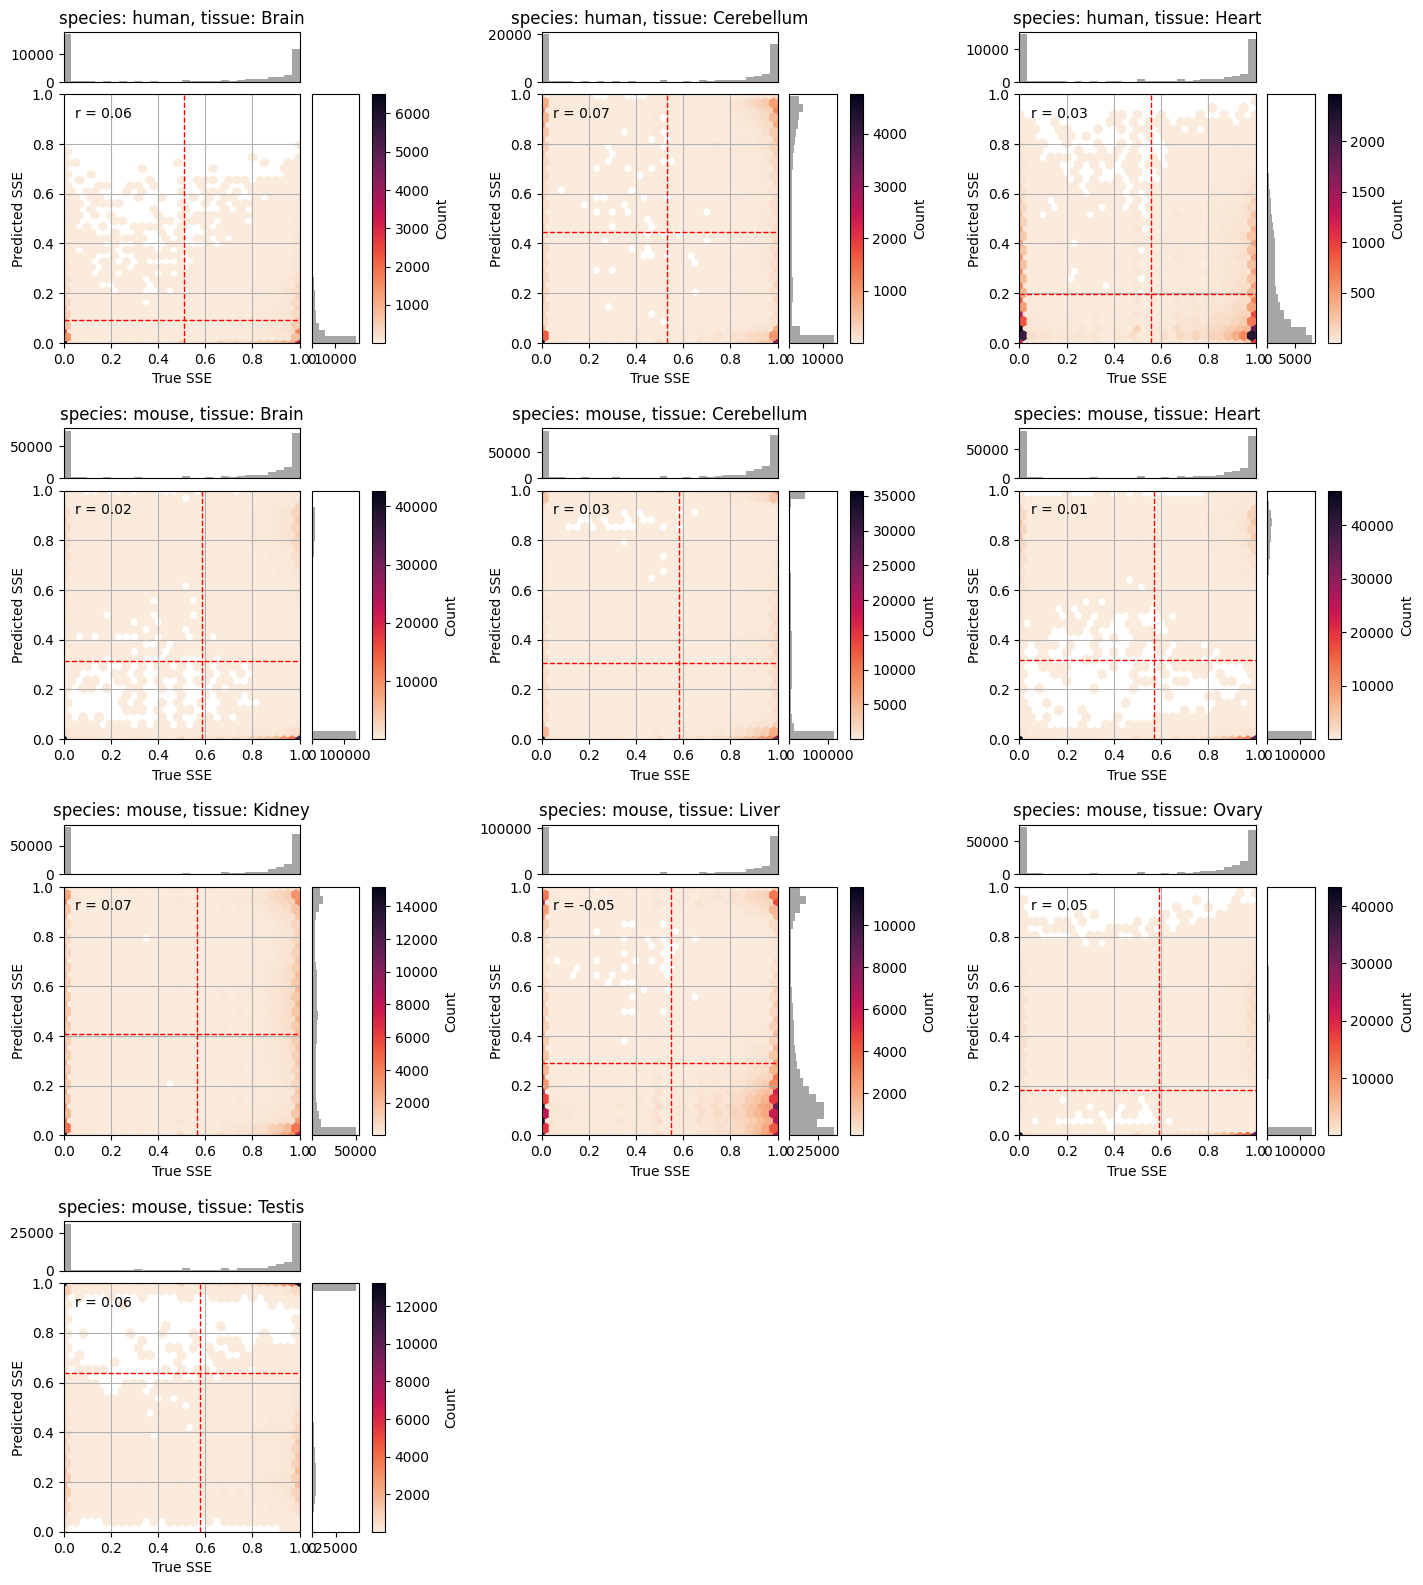

In [81]:
%matplotlib inline
plot_sse_density(
    usage_df, 
    group_by=['species', 'tissue']
)